# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

## Récupération des librairies

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

## Modèle de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [3]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Régression Logistique


In [12]:
# définition du modèle
clf_lr = LogisticRegression()

In [13]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [14]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_lr = {'solver':['sag'], 'C':[0.1], 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [15]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_lr = GridSearchCV(clf_lr, param_grid=param_grid_lr, scoring='f1_macro', n_jobs=-1, cv=3)

# entraînement du modèle
gcv_lr.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1],
                         'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.018367346938775512,
                                           1: 0.9816326530612245},
                                          {0: 0.036734693877551024,
                                           1: 0.963265306122449},
                                          {0: 0.05510204081632654,
                                           1: 0.9448979591836735},
                                          {0: 0.07346938775510205,
                                           1: 0.926530612244898},
                                          {0: 0.09183673469387756,
                                           1: 0.9081632653061225},
                                          {0: 0.110204081...
                                          {0: 0.42244897959183675,
                                           1: 0.5775510204081633},
                                          {0: 0.4408163265306123,
                                           1: 0.5591836734693877},
                                          {0: 0.4591836734693878,
                                           1: 0.5408163265306122},
                                          {0: 0.47755102040816333,
                                           1: 0.5224489795918367},
                                          {0: 0.49591836734693884,
                                           1: 0.5040816326530612},
                                          {0: 0.5142857142857143,
                                           1: 0.48571428571428565},
                                          {0: 0.5326530612244899,
                                           1: 0.46734693877551015}, ...],
                         'solver': ['sag']},
             scoring='f1_macro')

In [16]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas = gcv_lr.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.67).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_lr.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_lr.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_lr.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'C': 0.1, 'class_weight': {0: 0.49591836734693884, 1: 0.5040816326530612}, 'solver': 'sag'} 

Train Data Score: 0.771100638081438
Test Data Score: 0.7241468642999596

               precision    recall  f1-score   support

           0       0.89      0.89      0.89     21962
           1       0.62      0.62      0.62      6196

    accuracy                           0.83     28158
   macro avg       0.76      0.76      0.76     28158
weighted avg       0.83      0.83      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.89      0.62      0.89      0.75      0.57     21962
          1       0.62      0.62      0.89      0.62      0.75      0.54      6196

avg / total       0.83      0.83      0.68      0.83      0.75      0.57     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision et un rappel parfaitement équilibrés
- `un F1-score macro égal à 0.76`
- `une moyenne géométrique égale à 0.75`

### Interprétabilité du modèle

L'Analyse en Composantes Principales (PCA) permet de réduire le nombre de dimensions d'un jeu de données décrit par un grand nombre de variables. Cela permet une visualisation simplifiée des résultats du modèle.

In [17]:
# calcul de la PCA en ne conservant que deux axes
pca = PCA(n_components=2)

In [18]:
# récupération de la projection du jeu de données d'entraînement sur les deux axes principaux de la PCA 
X_new = pca.fit_transform(X_train_scaled)

xs = X_new[:,0]
ys = X_new[:,1]

In [19]:
# création d'un DataFrame pour stocker les projections standardisées sur chaque axe de la PCA 
scale_x = 1.0/(xs.max() - xs.min())
scale_y = 1.0/(ys.max() - ys.min())

principalDf = pd.DataFrame({'PC1': xs*scale_x, 'PC2': ys*scale_y})

In [20]:
# récupération des vecteurs propres et valeurs propres associées à la PCA
coeff = pca.components_.transpose()

In [21]:
# prédiction du modèle sur le jeu d'entraînement
y_train_pred = gcv_lr.predict(X_train_scaled)

In [22]:
# regroupement des projections standardisées sur chaque axe de la PCA et des prédictions du modèle 
# sur le jeu d'entraînement 
finalDF = pd.concat([principalDf, pd.Series(y_train_pred, name='RainTomorrow')], axis=1)

In [23]:
# aperçu du DataFrame
finalDF.head()

,PC1,PC2,RainTomorrow
0,0.191304,-0.064674,0
1,0.136410,0.270206,0
2,0.207125,0.328423,0
3,0.163046,0.121614,0
4,-0.084551,-0.277263,1


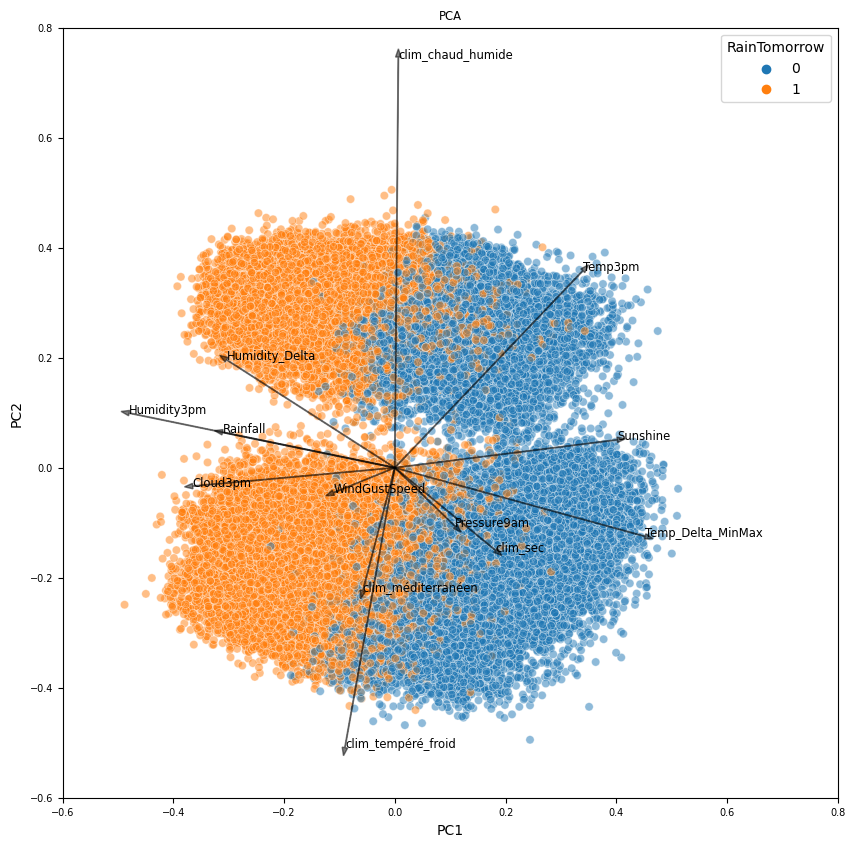

In [24]:
# visualisation des résultats de la PCA la projection des individus sur deux composantes sélectionnées et la 
# corrélation des variables avec ces composantes 
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue='RainTomorrow', data=finalDF, alpha=0.5)
for i in range(X_train_scaled.shape[1]):
    plt.arrow(0, 0, coeff[i,0]*1.05, coeff[i,1]*1.05, color='k', alpha=0.5, head_width=0.01)
    plt.text(coeff[i,0]*1.05, coeff[i,1]*1.05, X_train.columns[i], color='k', fontsize="small")
plt.xlim(-0.6, 0.8)
plt.ylim(-0.6, 0.8)
plt.title("PCA", fontsize="small")
plt.tick_params(labelsize=7);

Ce biplot nous permet de visualiser les classes de précipitations créées par notre modèle en fonction des variables explicatives dans le jeu d'entraînement. 

On observe que lorsqu'il pleut le lendemain, en général le temps est nuageux à 15h, l'humidité est importante à 15h, il y a des précipitations et la variation de l'humidité sur la journée est élevée. 

En revanche, lorsqu'il ne pleut pas le lendemain, la journée bénéficie d'un ensoleillement important, d'un climat sec, d'une forte température à 15h et la variation des températures sur la journée est élevée.

In [25]:
# conversion de l'ensemble d'entraînement standardisé en DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

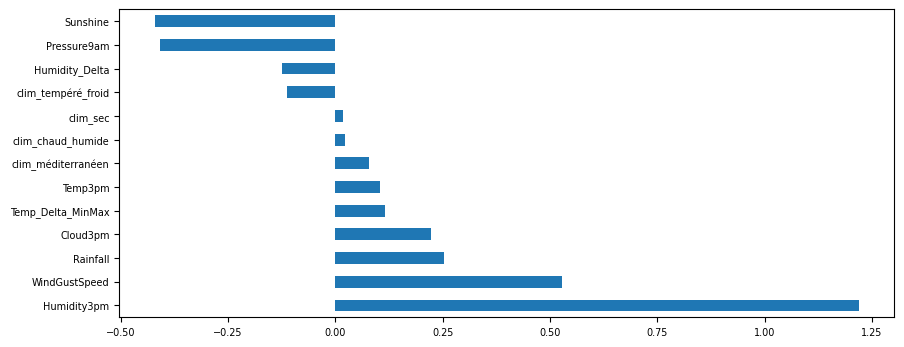

In [26]:
# affichage de l'importance des variables dans le jeu de données d'entraînement
pd.Series(gcv_lr.best_estimator_.coef_[0], X_train_scaled.columns) \
    .sort_values(ascending=False).plot(kind='barh', figsize=(10,4), fontsize="small")
plt.tick_params(labelsize=7);

Les coefficients du modèle de régression logistique permettent d'avoir un aperçu des relations faites par le modèle entre chaque variable explicative et la variable cible. 
Dans notre cas, la variable "Humidity3pm" est élévée cela signifie que plus l'humidité à 15h est importante et plus la probabilité qu'il pleuve le lendemain est importante.